### <b> Import Libraries and modules </b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
from sklearn.preprocessing import LabelEncoder
import joblib
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns


### <b> Load dataset </b>

In [2]:
df = DataFrame() 

LOS = pd.read_csv('LOS.csv',sep=',',parse_dates=True) #csv file
LOS

LOS.head() #first rows


,Gender,Ethnicity,Sector,District,Length of Stay,HealthcareWorker,WardUponAdmission,Hypertension,Diabetes,Asthma,...,ChronicPulmonaryDisease,ChronicRenalFailure,Malignancy,HivPositive,TuberculosisPast,Tuberculosis,Obesity,Risk Level,LOS_Category,Age_Group
0,Female,Black African,Public,Sarah Baartman,0,False,General Ward,No,No,No,...,No,No,No,Yes,No,No,Unknown,Moderate Risk,Short,30-39
1,Female,Black African,Public,Sarah Baartman,1,False,General Ward,Yes,No,No,...,No,No,No,No,Unknown,No,No,Moderate Risk,Short,80+
2,Female,Black African,Public,Chris Hani,1,False,General Ward,Yes,No,No,...,No,No,No,Unknown,Unknown,No,Unknown,Moderate Risk,Short,80+
3,Female,Black African,Public,Sarah Baartman,15,False,General Ward,No,No,No,...,No,No,No,Yes,Unknown,No,No,Moderate Risk,Long,40-49
4,Female,Black African,Public,Sarah Baartman,15,False,General Ward,No,No,No,...,No,No,No,No,Unknown,No,No,Low Risk,Long,30-39


#### <b> Data Preprocessing </b>

##### 1. Encoding X and Y

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming 'LOS' is your DataFrame and 'columns' is the list of feature columns
# Categorical columns for one-hot encoding
categorical_columns = ['Age_Group', 'Gender', 'Ethnicity', 'Sector', 'District', 'HealthcareWorker', 'WardUponAdmission', 'Hypertension', 'Diabetes',
       'Asthma', 'CardiacDisease', 'ChronicPulmonaryDisease','ChronicRenalFailure', 'Malignancy', 'HivPositive', 'TuberculosisPast',
       'Tuberculosis', 'Obesity', 'Risk Level']
label_column= 'LOS_Category'

# One-hot encoding for X columns
X_encoded = pd.get_dummies(LOS[categorical_columns])

# Convert boolean values to integers (0 or 1) if needed
X_encoded = X_encoded.astype(int)

# Label encoding for Y (DischargeStatus)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(LOS[label_column])


# Print encoded X and Y
#X_encoded.info()
print(Y_encoded)


[1 1 1 ... 1 1 1]


#### 2. OverSampling

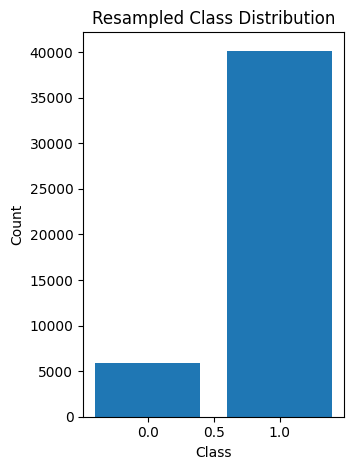

In [4]:
import matplotlib.pyplot as plt

# Count the occurrences of each class after oversampling
resampled_class_counts = pd.Series(Y_encoded).value_counts()


plt.subplot(1, 2, 2)
plt.bar(resampled_class_counts.index, resampled_class_counts.values)
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### 3. Training and Testing Sets - Dataset Split

In [5]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y_encoded, test_size=0.3, random_state=42)

# Print the shapes of the training and testing sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (32235, 70)
X_test shape: (13816, 70)
y_train shape: (32235,)
y_test shape: (13816,)


In [6]:
# Verify data is binary (0 or 1)
print("Unique values in X_train:", np.unique(X_train))
# Should print only [0, 1]

Unique values in X_train: [0 1]


#### 4. Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

X_test_scaled

array([[-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       ...,
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421]])

### <b>Model Training and Testing</b>

In [8]:
# Define your binary classes clearly
label_mapping = {0: 'Short', 1: 'Long'}

# Apply label encoding
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(LOS[label_column])

# Verify the label mapping
print("Encoded classes:", label_encoder.classes_)

Encoded classes: ['Long' 'Short']


In [9]:
# Logistic Regression Implementation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Initialize Logistic Regression
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Fit the model on the scaled training data
logreg_model.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred_logreg = logreg_model.predict(X_test_scaled)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')
precision_logreg = precision_score(y_test, y_pred_logreg, average='weighted')
recall_logreg = recall_score(y_test, y_pred_logreg, average='weighted')


# Output performance
print("Logistic Regression Test Accuracy:", accuracy_logreg)
print("Logistic Regression F1 Score:", f1_logreg)
print("Logistic Regression Precision:", precision_logreg)
print("Logistic Regression Recall:", recall_logreg)




Logistic Regression Test Accuracy: 0.8720324261725536
Logistic Regression F1 Score: 0.8131146109478826
Logistic Regression Precision: 0.8119941138185767
Logistic Regression Recall: 0.8720324261725536


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # This returns a NumPy array
X_test_scaled = scaler.transform(X_test)

# Preserve column names after scaling
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)



## Feature Importance 

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

Top 10 Permutation Importances:
                               Feature  Importance Mean  Importance Std
56                    HivPositive_Yes         0.000080        0.000060
43             CardiacDisease_Unknown         0.000087        0.000101
8                     Age_Group_70-79         0.000094        0.000073
62                   Tuberculosis_Yes         0.000094        0.000138
10                      Gender_Female         0.000109        0.000087
34               Hypertension_Unknown         0.000109        0.000118
42                  CardiacDisease_No         0.000130        0.000120
26  District_Nelson Mandela Bay Metro         0.000138        0.000139
57                TuberculosisPast_No         0.000405        0.000261
58           TuberculosisPast_Unknown         0.000594        0.000323


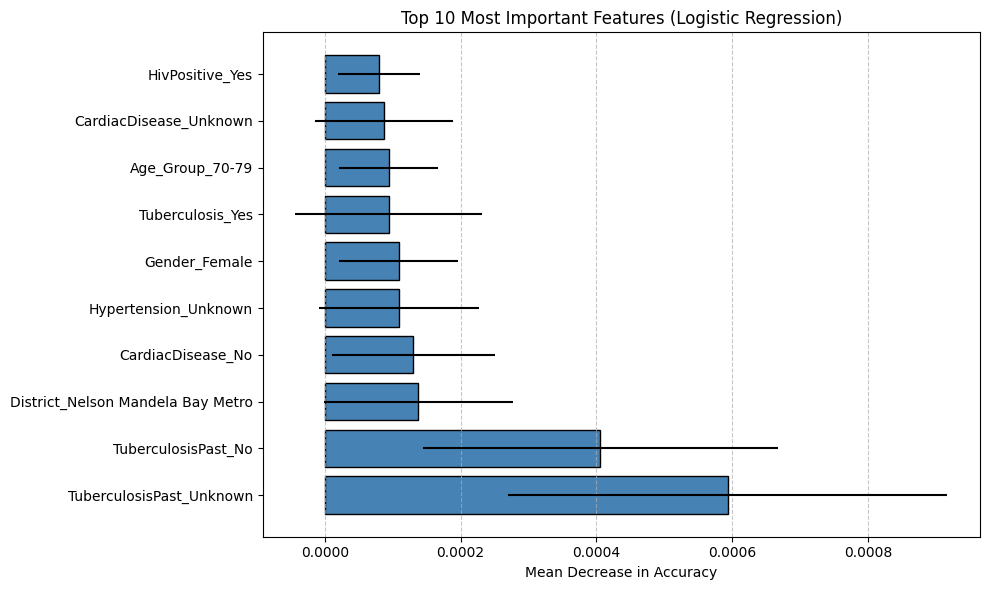

In [11]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Feature names from scaled DataFrame
feature_names = X_train_scaled.columns

# Compute permutation importance
perm_importance = permutation_importance(
    logreg_model, X_test_scaled, y_test,
    n_repeats=10, random_state=42, scoring='accuracy'
)

# Create DataFrame with importance metrics
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})

# Sort by importance descending
perm_df = perm_df.sort_values(by='Importance Mean', ascending=False)

# Display top 10
top_n = 10
top_features = perm_df.head(top_n).sort_values(by='Importance Mean', ascending=True)  # sort for clean horizontal plot
print(f"Top {top_n} Permutation Importances:\n", top_features)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance Mean'],
         xerr=top_features['Importance Std'], color='steelblue', edgecolor='black')
plt.xlabel("Mean Decrease in Accuracy")
plt.title(f"Top {top_n} Most Important Features (Logistic Regression)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities for the positive class (class 1)
y_pred_proba = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_proba)

# Print AUC
print("Logistic Regression AUC Score:", auc_score)

Logistic Regression AUC Score: 0.6589024825777833


C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


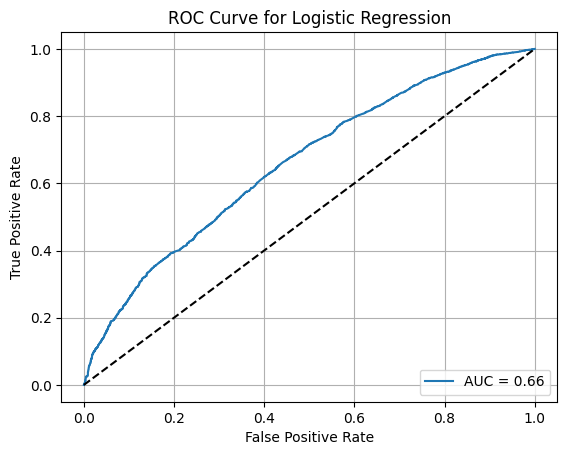

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [14]:
# Extracting coefficients
feature_names = X_encoded.columns
coefficients = logreg_model.coef_[0]

# Create a DataFrame for easy interpretation
import pandas as pd

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
}).sort_values(by='Coefficient', ascending=False)

# Display the coefficients and odds ratios
print(coef_df)

                                  Feature  Coefficient  Odds Ratio
21                    District_Alfred Nzo     0.259040    1.295685
1                           Age_Group_0-9     0.219222    1.245108
57                    TuberculosisPast_No     0.156784    1.169743
20                          Sector_Public     0.151787    1.163913
2                         Age_Group_10-19     0.118595    1.125914
..                                    ...          ...         ...
48                 ChronicRenalFailure_No    -0.094675    0.909669
31  WardUponAdmission_Intensive Care Unit    -0.113342    0.892845
26      District_Nelson Mandela Bay Metro    -0.140870    0.868602
19                         Sector_Private    -0.151787    0.859171
58               TuberculosisPast_Unknown    -0.172162    0.841843

[70 rows x 3 columns]


In [15]:
# Top positive and negative features influencing predictions
print("Top Positive Features:")
print(coef_df.head(10))

print("\nTop Negative Features:")
print(coef_df.tail(10))

Top Positive Features:
                           Feature  Coefficient  Odds Ratio
21             District_Alfred Nzo     0.259040    1.295685
1                    Age_Group_0-9     0.219222    1.245108
57             TuberculosisPast_No     0.156784    1.169743
20                   Sector_Public     0.151787    1.163913
2                  Age_Group_10-19     0.118595    1.125914
29  WardUponAdmission_General Ward     0.114766    1.121611
49     ChronicRenalFailure_Unknown     0.111954    1.118461
28         District_Sarah Baartman     0.098651    1.103681
25              District_Joe Gqabi     0.083989    1.087617
65                     Obesity_Yes     0.059782    1.061606

Top Negative Features:
                                  Feature  Coefficient  Odds Ratio
27                     District_O R Tambo    -0.062838    0.939095
53                         Malignancy_Yes    -0.069764    0.932614
62                       Tuberculosis_Yes    -0.081877    0.921385
23            District_Bu

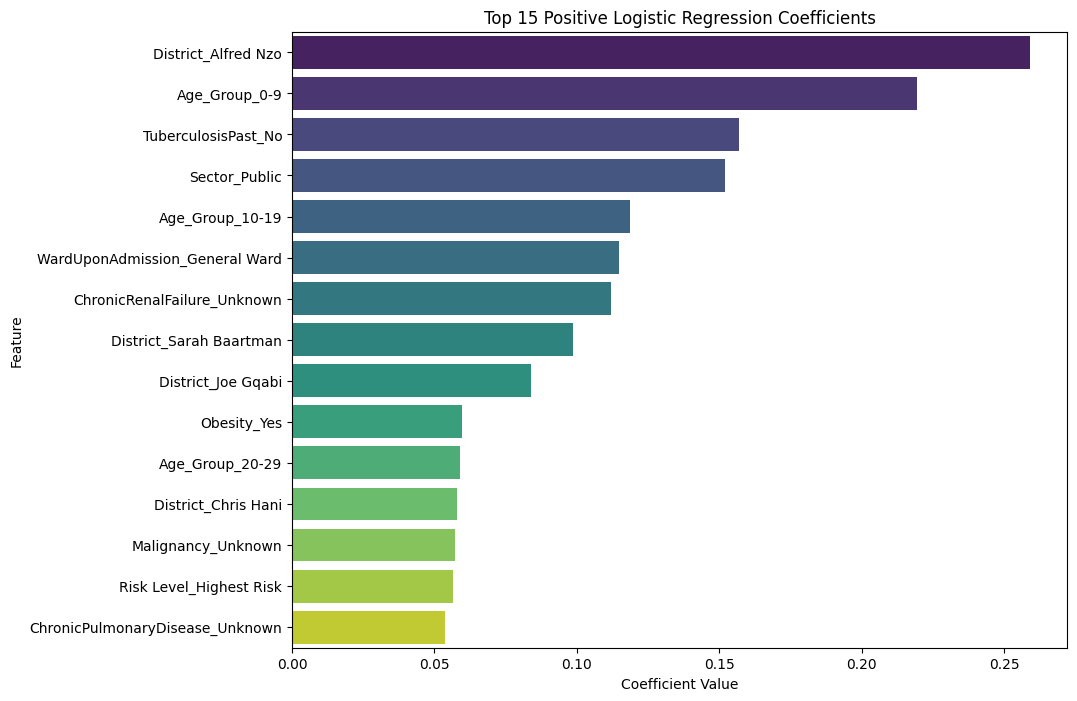

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15), palette='viridis')
plt.title('Top 15 Positive Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [17]:
import numpy as np

# Get the feature names and corresponding coefficients
coefficients = logreg_model.coef_[0]  # [0] because it's binary classification
feature_names = X_train_scaled.columns

# Create a DataFrame for better readability
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Add Odds Ratio
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])

# Sort by absolute coefficient value for better impact ranking
coef_df['Abs Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs Coefficient', ascending=False)

# Display top features
top_n = 10
print(f"Top {top_n} Most Influential Logistic Regression Coefficients:\n")
print(coef_df[['Feature', 'Coefficient', 'Odds Ratio']].head(top_n))


Top 10 Most Influential Logistic Regression Coefficients:

                                  Feature  Coefficient  Odds Ratio
21                    District_Alfred Nzo     0.259040    1.295685
1                           Age_Group_0-9     0.219222    1.245108
58               TuberculosisPast_Unknown    -0.172162    0.841843
57                    TuberculosisPast_No     0.156784    1.169743
20                          Sector_Public     0.151787    1.163913
19                         Sector_Private    -0.151787    0.859171
26      District_Nelson Mandela Bay Metro    -0.140870    0.868602
2                         Age_Group_10-19     0.118595    1.125914
29         WardUponAdmission_General Ward     0.114766    1.121611
31  WardUponAdmission_Intensive Care Unit    -0.113342    0.892845


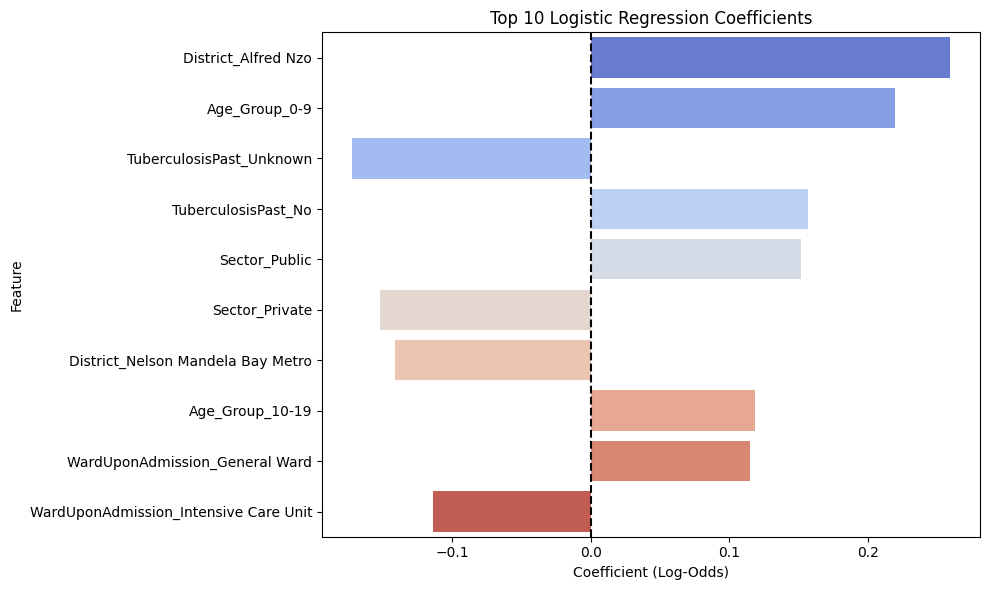

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the top n coefficients (positive and negative)
top_coef_df = coef_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_coef_df, palette='coolwarm')
plt.axvline(0, color='black', linestyle='--')
plt.title(f"Top {top_n} Logistic Regression Coefficients")
plt.xlabel("Coefficient (Log-Odds)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Coefficients
coef_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)




print(coef_df)

                                  Feature  Coefficient
21                    District_Alfred Nzo     0.259040
1                           Age_Group_0-9     0.219222
57                    TuberculosisPast_No     0.156784
20                          Sector_Public     0.151787
2                         Age_Group_10-19     0.118595
..                                    ...          ...
48                 ChronicRenalFailure_No    -0.094675
31  WardUponAdmission_Intensive Care Unit    -0.113342
26      District_Nelson Mandela Bay Metro    -0.140870
19                         Sector_Private    -0.151787
58               TuberculosisPast_Unknown    -0.172162

[70 rows x 2 columns]


In [20]:
np.exp(coef_df['Coefficient'])

21    1.295685
1     1.245108
57    1.169743
20    1.163913
2     1.125914
        ...   
48    0.909669
31    0.892845
26    0.868602
19    0.859171
58    0.841843
Name: Coefficient, Length: 70, dtype: float64

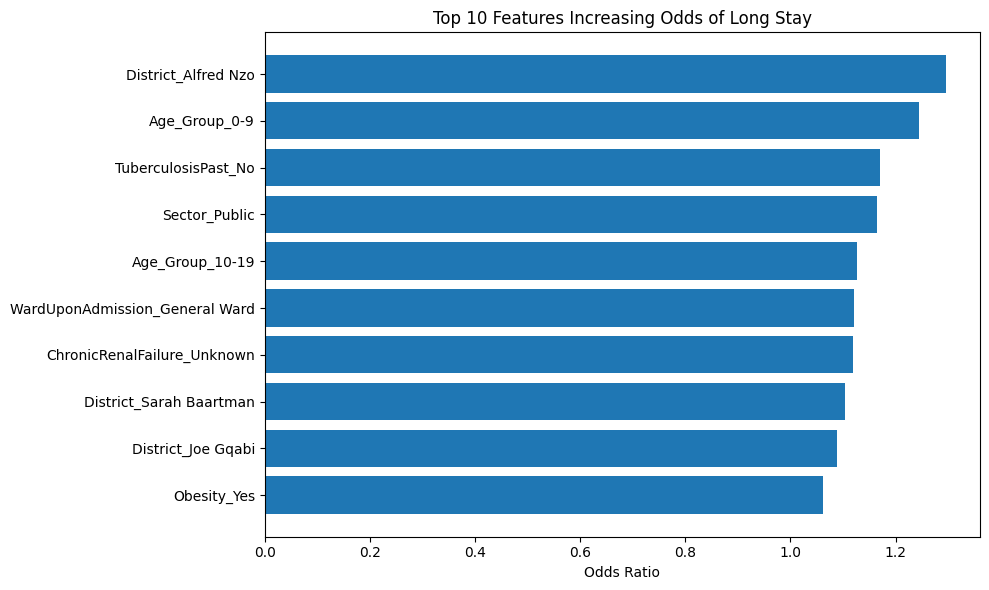

In [21]:
import matplotlib.pyplot as plt

# Assuming coef_df["OddsRatio"] contains these values and "Feature" column exists
coef_df["OddsRatio"] = np.exp(coef_df["Coefficient"])

# Plot top 10 most impactful features
top_features = coef_df.sort_values(by="OddsRatio", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['OddsRatio'])
plt.xlabel('Odds Ratio')
plt.title('Top 10 Features Increasing Odds of Long Stay')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()